# Modelo integra-e-dispara simplificado

A implementação do modelo integra e dispara simplificado deriva da modelagem matemática do neurônio como um **circuito RC**. A membrana neuronal exerce o papel de capacitor e os canais iônicos papel semelhante a um resistor. A manutenção do potencial de repouso se dá pelas bombas de sódio e potássio, que podem se prestar ao papel de uma bateria.

## Dinâmica

A dinâmica desse modelo, com enfoque no potencial de membrana, tem como resultado uma dinâmica linear:
$$
\frac{dV}{dt} = a(V - V_\text{rep}) \quad | \quad a < 0
$$

> Quanto mais distante o estímulo está do potencial de repouso, mais brusco é o retorno ao potencial. Porém todos retornam a uma taxa constante.

A determinação da constante $a$ pode ser feita por meio experimental, mas é possível obter um resultado mais preciso ao considerar o produto da capacitância da membrana e a resistência -> $RC$. Esse produto é conhecido como **constante temporal de membrana**. A constante temporal define o taxa de decaímento ou crescimento.Também pode ser denotada pela letra $\tau$
$$
\frac{dV}{dt} = -\frac{V - V_\text{rep}}{RC} = -\frac{V - V_\text{rep}}{\tau}
$$


Outro ponto a ser levado em consideração é a composição da constante $V_\text{rep}$ que corresponde ao pontencial de repouso da membrana. Essa constante na verdade pode ser modificada caso o neurônio receba estímulos, como PIPS e PEPS, levando o neurônio a um novo patamar de repouso o quanto o estímulo durar. Portanto torna-se conveniente adotar uma nova constante, conhecida como $V_\infty$:
$$
V_\infty = V_\text{rep} + E_r
$$

Onde $E_r$ é o potencial do estímulo aplicado a membrana.

## Resolução pelo método de euler

<IPython.core.display.Javascript object>


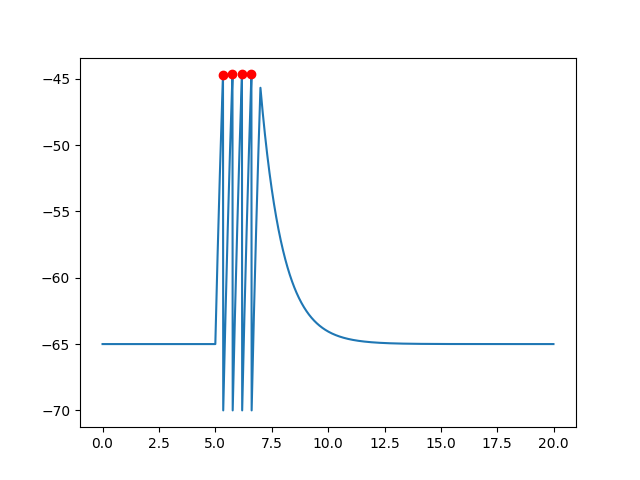

In [64]:
%matplotlib notebook
import numpy as np
from matplotlib import pyplot as plt

# Derivada da eq. de membrana
def dt_eq_membrana(V,Vrep,Er,R,C):
    return -(V - (Vrep + Er))/R*C


# Integra e dispara método de Euler
def integra_dispara_euler(func, y0=-65, h=0.01, passos=1000, pulsos = [], limiar=-45, reset=-70, R=1,C=1):
    t = np.zeros(passos)  # Array para valores do tempo t_i 
    y = np.zeros(passos)  # Array para valores dos potenciais V_i
    Er = np.zeros(passos) # Array para os estímulos aplicados a membrana
    disparos = [] #Array para guardar os disparos
    
    for pulso in pulsos:
        Er[pulso['t_i']*100:pulso['t_f']*100] = pulso['V']
            
    y[0] = y0
    for i in range(passos - 1): 
        t[i + 1] = t[i] + h 
        if y[i] >= limiar:
            disparos.append(i)
            y[i+1] = reset
        else:
            y[i + 1] =  y[i] + h*func(y[i], y0, Er[i], R, C)

            

    return t, y, disparos

# Pulsos retangulares aplicados sobre a membrana
# t_i - tempo inicial
# t_f - tempo final
# V - potencial do pulso

pulsos_retangulares = [{'t_i': 5,'t_f': 7, 'V':70}]


t, V, disparos = integra_dispara_euler(dt_eq_membrana, -65, pulsos=pulsos_retangulares, passos=2000)

plt.plot(t, V, '-')
plt.plot(t[disparos], V[disparos], 'or')
